<a href="https://colab.research.google.com/github/Clarke-Henshaw-Miles/extra/blob/master/DATA%20SCIENCE/Chapter7Attempt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# To be completed at the Live Session and in your own time.

These set of examples we will help you get familiar with non parametric tests and correlations within a Jupyter notebook.   The questions coloured green are important practice for CA, particularly CA 2.

Before attempting these examples, please ensure you have read through [Chapter 7 Jupyter Notebook](https://github.com/haleygomez/Data-Science-2024/blob/main/blended_exercises/Chapter7/Chapter7.ipynb) and have completed the Learning Central **Chapter 7 quiz**.

***

# MCMC

## <font color=#30a64d>Question</font>

In Chapter 6, we saw that Professor Dumbledore, studying the extinction of dragons, discovers a new set of egg remnants in an unexplored valley in Madagascar. The remnants are radio carbon dated and found to have the following ages in years:

2141.22, 1781.15, 1523.37, 1816.90, 1932.29, 1541.21, 720.782, 1026.22, 1687.22, 2460.59

Professor Snape however did a previous study in the next valley where he found eggs that were on average 1200 years old, following a normal distribution with standard deviation of 300 years.

- Write an MCMC algorithm from scratch and use it to create a posterior distribution for the mean age of the eggs. What is the mean and variance for the posterior using your MCMC distribution?

- Check the MCMC has converged.

- How does this compare with the analytical values you derived in Chapter 6?

### Answer

So from Chapter 6 we already derived an analytical posterior with mean of 1568.73 +/ 150.56 year.

Now we do the same using MCMC.

MCMC gives the posterior dist for the mean age of the eggs by creating a large sample of $\theta$ and calculating the posterior for the sample.

The denominator (the evidence) is a constant for normalization and does not effect shape of dist so we can ignore it for now and only use the numerator (likelihood x prior).


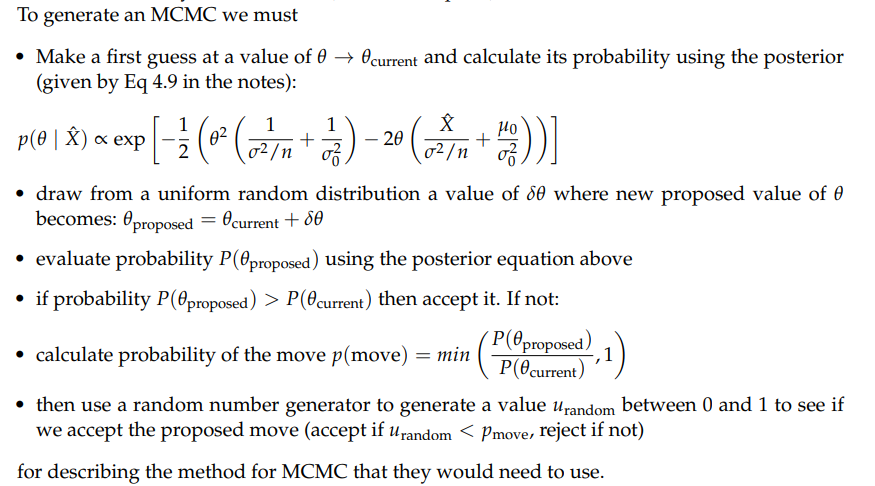

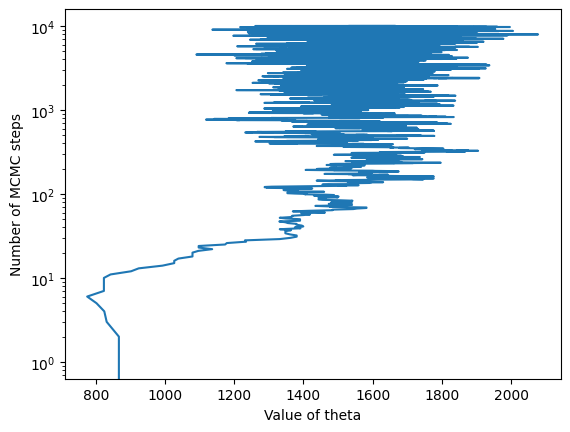

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

%matplotlib inline

# define a function for the probability
# prob(posterior) = normal(likelihood) x normal(prior)
#get the unnormalised pdf of the posterior (numerator)
def posterior(theta):
    data = [2141.22, 1781.15, 1523.37, 1816.90, 1932.29, 1541.21, 720.782, 1026.22, 1687.22, 2460.59]
    X_hat = np.mean(data)
    n = len(data)
    s_d = np.sqrt((1/(n-1))*(np.sum((data-X_hat)**2)))
      #s_d = np.std(data)
    var = s_d**2/n
    mu_0 = 1200
    s_0 = 300
    val = np.exp(-0.5 * (theta**2 * ((1/(var)) + (1/s_0**2)) - (2*theta * ((X_hat/var) + (mu_0/s_0**2)))))
    return val

# set up MCMC step paramaters
N_mcmc = 10000
theta_current = np.zeros(N_mcmc+1)
# use our prior as a guess
theta_current[0] = 800

# choose a value for width of normal distribution to get the step in height
# this is between the prior and the likelihood values
sigma_mcmc = 50

#interested in keeping track of rejected thetas
i_rej = []
theta_rej = []


for i in range(N_mcmc):
    p_current = posterior(theta_current[i]) # put current value in posterior equation
    dtheta = np.random.normal(0,sigma_mcmc) # randomally draw a value of theta to trial
    theta_proposed = theta_current[i] + dtheta #get new proposed theta (random theta + stepsize)
    p_proposed = posterior(theta_proposed) # calculate posterior p for proposed theta

    #  keep this value if probability proposed theta greater than the current prob
    if p_proposed > p_current:
        theta_current[i+1] = theta_proposed
    else:
    # if probability lower
    # use the ratios of probability to define probability of whether we move to that value or not
        p_new_move = p_proposed/p_current
        # generate random number for probability
        u_random = np.random.uniform(0,1)
        # if u_random < p_new_move, then accept, if not, reject
        if u_random <= p_new_move:
            theta_current[i+1] = theta_proposed
        else:
            theta_current[i+1] = theta_current[i]
            theta_rej.append(theta_proposed)
            i_rej.append(i)

#generate the walk for plotting
x_mcmc = np.linspace(0,N_mcmc,N_mcmc+1)

plt.semilogy(theta_current, x_mcmc)
plt.xlabel('Value of theta')
plt.ylabel('Number of MCMC steps')
plt.show()


The mean of the posterior from the MCMC distribution is 1565.58 +/- 150.72 years.


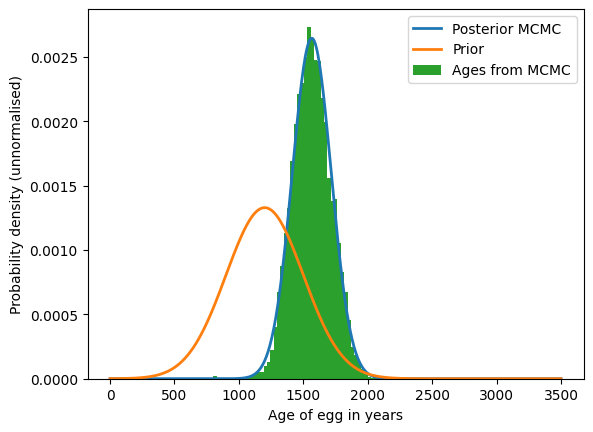

In [2]:
theta_mean_mcmc = np.mean(theta_current)
theta_std_mcmc = np.sqrt((1/(len(theta_current-1))*np.sum((theta_current-theta_mean_mcmc)**2)))
#np.std(theta_current)

print("The mean of the posterior from the MCMC distribution is {:.2f} +/- {:.2f} years.".format(theta_mean_mcmc, theta_std_mcmc))

x = np.linspace(0, 3500, 500)
posterior_mcmc = norm.pdf(x, theta_mean_mcmc, theta_std_mcmc)

mu_0 = 1200
sigma_0 = 300
prior = norm.pdf(x, mu_0, sigma_0)

plt.plot(x, posterior_mcmc, lw=2, label='Posterior MCMC')
plt.plot(x, prior, lw=2, label='Prior')
plt.hist(theta_current, bins=50, density=True, label='Ages from MCMC')
plt.xlabel('Age of egg in years')
plt.ylabel('Probability density (unnormalised)')
plt.legend()
plt.show()

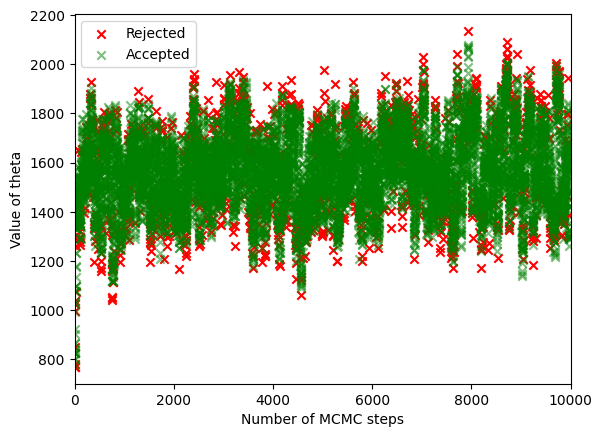

In [3]:
#look at accepted and rejected values
plt.scatter(i_rej, theta_rej, color='r', marker='x', label='Rejected')
plt.scatter(x_mcmc, theta_current, color='g', marker='x', alpha=0.5, label='Accepted')
plt.xlabel('Number of MCMC steps')
plt.ylabel('Value of theta')
plt.xlim(0, N_mcmc)
plt.legend(scatterpoints=1)
plt.show()

Burnin can reduce the dependence of the reconstructed distribution on the initial position. We haven't done any burnin in this case as we have large N and started our guess close to the prior mean. However, if we had started further away, we could inspect the chain and determine how many of the first N data points to burn (remove).

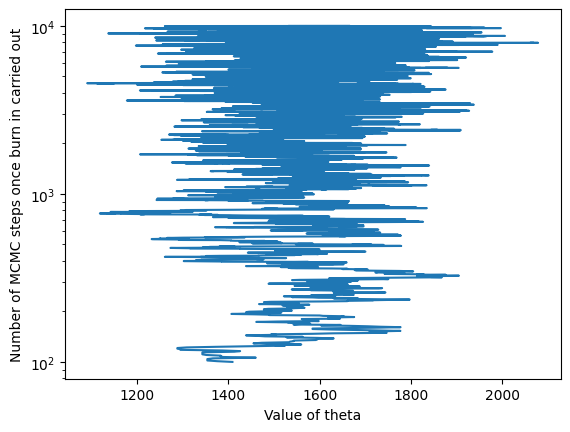

In [4]:
#generate walk for plotting after burning first 100 iterations
burn = 100
plt.semilogy(theta_current[burn:], x_mcmc[burn:])
plt.xlabel('Value of theta')
plt.ylabel('Number of MCMC steps once burn in carried out')
plt.show()

### Thinning:

- Only accepting each nth value from the chain and removing the rest.

- Useful when the MCMC results look clumpy as they do above, and this can help counteract any correlations in the walk.

- To decide on this can throw away values after looking at the data, or just look for correlations on sets of n points.

### Convergence:

- Need to explain or test for convergence by running the same MCMC or trialling multiple initial guesses far away from the prior values to show they all converge ultimately.

- Can also use the difference in means of the output values.

- As the method converges the mean should settle to a value and the difference in means for each sample set tends
to zero.

- If the method was non convergent then the mean would constantly move and the difference in means will always be > 0 for explanation/discussion.

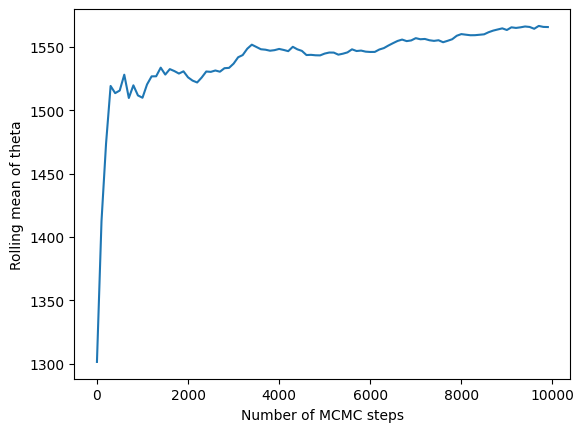

In [5]:
#work out means of subsets
converge_test = int(N_mcmc/100)
converge_mean = np.zeros(converge_test)
c_x = np.zeros(converge_test)

for i in range(0, converge_test):
    converge_mean[i] = np.mean(theta_current[0:(i+1)*100])
    c_x[i] = i*100

plt.plot(c_x, converge_mean)
plt.xlabel('Number of MCMC steps')
plt.ylabel('Rolling mean of theta')
plt.show()

Now replot and recalculate mean after the thinning/burn in:

The mean of the posterior from the MCMC distribution is 1568.25 +/- 147.31 years.


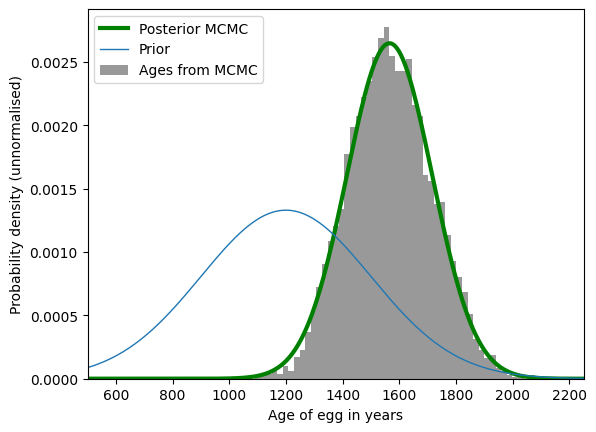

In [6]:
theta_mean_mcmc = np.mean(theta_current[burn:])
theta_std_mcmc = np.sqrt((1/(len(theta_current[burn:]-1))*np.sum((theta_current[burn:]-theta_mean_mcmc)**2)))
#np.std(theta_current)

print("The mean of the posterior from the MCMC distribution is {:.2f} +/- {:.2f} years.".format(theta_mean_mcmc, theta_std_mcmc))

x = np.linspace(0, 3500, 500)

mu_0 = 1200
sigma_0 = 300
prior = norm.pdf(x, mu_0, sigma_0)

plt.plot(x, posterior_mcmc, c='green', lw=3, label='Posterior MCMC')
plt.plot(x, prior, lw=1, label='Prior')
plt.hist(theta_current[burn:], bins=50, density=True, alpha=0.8, color='grey', label='Ages from MCMC')
plt.xlabel('Age of egg in years')
plt.ylabel('Probability density (unnormalised)')
plt.xlim(500, 2250)
plt.legend()
plt.show()

Compare with our analytical one:

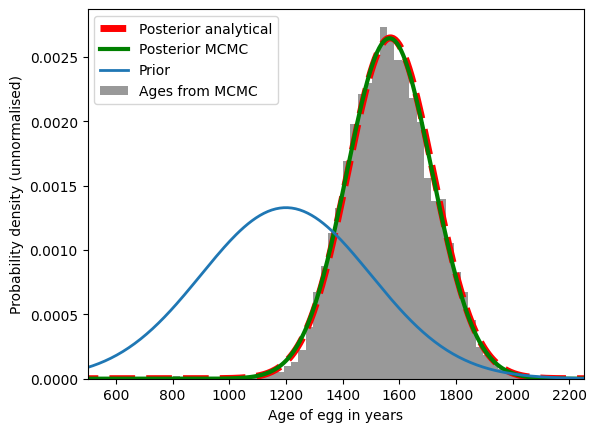

The mean of the posterior from the MCMC distribution is 1568.25 +/- 147.31 years.
The mean from the analytical posterior is 1568.73 +- 150.56 years.


In [7]:
#analytical expression from chapter 6
X_hat = 1568.73
X_error_on_mean = 150.56
posterior_ana = norm.pdf(x, X_hat, X_error_on_mean)

plt.plot(x, posterior_ana, c='red', lw=5, ls='--', label='Posterior analytical')
plt.plot(x, posterior_mcmc, c='green', lw=3, label='Posterior MCMC')
plt.plot(x, prior, lw=2, label='Prior')
plt.hist(theta_current, bins=50, density=True, alpha=0.8, color='grey', label='Ages from MCMC')
plt.xlabel('Age of egg in years')
plt.ylabel('Probability density (unnormalised)')
plt.xlim(500, 2250)
plt.legend()
plt.show()

print('The mean of the posterior from the MCMC distribution is {:.2f} +/- {:.2f} years.'.format(theta_mean_mcmc, theta_std_mcmc))
print('The mean from the analytical posterior is {:.2f} +- {:.2f} years.'.format(X_hat, X_error_on_mean))


***